In [1]:
# Import Packages
import numpy as np
import pandas as pd
import pyodbc

# Get Current time
import datetime 

# For Graphics
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For splitting data into test and train subsets
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

# For logistic regression
from sklearn.linear_model import LogisticRegression

# For saving the model
from sklearn.externals import joblib 

# For Confusion Matrix
from sklearn import metrics

# For ROC Curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

# For Normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# For Feature Selection
from sklearn.feature_selection import chi2, SelectKBest

# Settings to view all columns and rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

#to ignore the warning lines from being printed
import warnings
warnings.filterwarnings('ignore')

C:\Users\aaacharya\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
df_orig = pd.read_excel('pnc_agent_churn.xlsx')
df_orig.head()

Agent_Number  Date_of_Appointment  Date_of_Termination Agent_Type  \
0          1565             20150101                  NaN         20   
1          1646             20150201                  NaN          1   
2          1717             20120101                  NaN          1   
3          2197             20150601                  NaN          1   
4          2332             20150601                  NaN          1   

  Agent_Branch_Code  Agent_Reporting_Level Territory Source Major_Class  \
0                10                      1       L      FOW               
1                10                      1       L      AGY               
2                10                      1       L      AGY               
3                10                      1       L      AGY               
4                10                      1       L      AGY               

  Statistical_Code Distribution_Channel Product_Category  Credit_Limit  \
0                                                    NaN             0   
1                                                    NaN             0   
2                                                    NaN             0   
3                                                    NaN             0   
4                                                    NaN             0   

  Settlement_Basis Reconciliation  Agent_Date_of_Birth Agent_Gender  \
0                                           20150101.0                
1                                                  NaN                
2                                                  NaN                
3                                           20150601.0            M   
4                                           19801011.0            M   

   Number_of_Policies  Number_of_Claims  Total_Claim_Paid_Amount  \
0                   1                 0                      0.0   
1                   3                 1                      0.0   
2                   0                 0                      0.0   
3                   1                 0                      0.0   
4                   1                 1                      0.0   

   Total_Commission_Amount  Churn  
0                      0.0      0  
1                      0.0      0  
2                      0.0      0  
3                      0.0      0  
4                      0.0      0

# Data treatment

In [3]:
# Check data shape
df_orig.shape

(10407, 22)

In [4]:
# Check data attributes of the columns
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 22 columns):
Agent_Number               10407 non-null int64
Date_of_Appointment        10407 non-null int64
Date_of_Termination        9 non-null float64
Agent_Type                 10407 non-null object
Agent_Branch_Code          10407 non-null object
Agent_Reporting_Level      10407 non-null int64
Territory                  10407 non-null object
Source                     10407 non-null object
Major_Class                10407 non-null object
Statistical_Code           10407 non-null object
Distribution_Channel       10407 non-null object
Product_Category           9857 non-null object
Credit_Limit               10407 non-null int64
Settlement_Basis           10407 non-null object
Reconciliation             10407 non-null object
Agent_Date_of_Birth        3667 non-null float64
Agent_Gender               10407 non-null object
Number_of_Policies         10407 non-null int64
Number_of_Claims  

Need to change data types of few columns, will do so in data processing section

In [5]:
# View distribution of 'Lapse' Instances
df_orig['Churn'].value_counts()

0    10398
1        9
Name: Churn, dtype: int64

Data is highly imbalanced, need to take this in scope


In [6]:
# Check if there are any nulls
df_orig.isnull().sum()

Agent_Number                   0
Date_of_Appointment            0
Date_of_Termination        10398
Agent_Type                     0
Agent_Branch_Code              0
Agent_Reporting_Level          0
Territory                      0
Source                         0
Major_Class                    0
Statistical_Code               0
Distribution_Channel           0
Product_Category             550
Credit_Limit                   0
Settlement_Basis               0
Reconciliation                 0
Agent_Date_of_Birth         6740
Agent_Gender                   0
Number_of_Policies             0
Number_of_Claims               0
Total_Claim_Paid_Amount        0
Total_Commission_Amount        0
Churn                          0
dtype: int64

# Data Treatment

In [7]:
# Create a copy of dataframe
df_work = df_orig.copy()

In [8]:
# Separate features into categorical and numerical category
cat_vars = df_work.select_dtypes(include=['object']).copy()

num_vars = df_work.select_dtypes(exclude=['object']).copy()
num_vars = num_vars.drop('Date_of_Appointment', axis=1)
num_vars = num_vars.drop('Date_of_Termination', axis=1)
num_vars = num_vars.drop('Agent_Date_of_Birth', axis=1)

date_vars = ['Date_of_Appointment', 'Date_of_Termination', 'Agent_Date_of_Birth' ]

In [9]:
cat_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 11 columns):
Agent_Type              10407 non-null object
Agent_Branch_Code       10407 non-null object
Territory               10407 non-null object
Source                  10407 non-null object
Major_Class             10407 non-null object
Statistical_Code        10407 non-null object
Distribution_Channel    10407 non-null object
Product_Category        9857 non-null object
Settlement_Basis        10407 non-null object
Reconciliation          10407 non-null object
Agent_Gender            10407 non-null object
dtypes: object(11)
memory usage: 894.4+ KB


In [10]:
num_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 8 columns):
Agent_Number               10407 non-null int64
Agent_Reporting_Level      10407 non-null int64
Credit_Limit               10407 non-null int64
Number_of_Policies         10407 non-null int64
Number_of_Claims           10407 non-null int64
Total_Claim_Paid_Amount    10407 non-null float64
Total_Commission_Amount    10407 non-null float64
Churn                      10407 non-null int64
dtypes: float64(2), int64(6)
memory usage: 650.5 KB


In [11]:
date_vars

['Date_of_Appointment', 'Date_of_Termination', 'Agent_Date_of_Birth']

In [12]:
# Convert date columns

for var in date_vars:
    #df_work[var] = df_work[var].astype('category')
    #df_work[var] = datetime.datetime.strptime(var, '%Y-%m-%d')
    df_work[var]=pd.to_datetime(df_work[var].astype(str), format='%Y%m%d')

In [13]:
# Convert to 'category' object type
for var in cat_vars:
    df_work[var] = df_work[var].astype('category')

In [14]:
# Create Dummy Variables for categorical variables
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(df_work[var], prefix=var)
    dummy_data = df_work.join(cat_list)
    df_work = dummy_data

In [15]:
# Check data shape after dummy encoding
df_work.shape

(10407, 99)

In [16]:
# Remove original columns for which dummy variables have been created
vars_remove = cat_vars

for var in vars_remove:
    df_work=df_work.drop(var, axis=1)

In [17]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['Agent_Reporting_Level'] = scaler.fit_transform(df_work['Agent_Reporting_Level'].values.reshape(-1,1))
df_work['Credit_Limit'] = scaler.fit_transform(df_work['Credit_Limit'].values.reshape(-1,1))
df_work['Number_of_Policies'] = scaler.fit_transform(df_work['Number_of_Policies'].values.reshape(-1,1))
df_work['Number_of_Claims'] = scaler.fit_transform(df_work['Number_of_Claims'].values.reshape(-1,1))
df_work['Total_Claim_Paid_Amount'] = scaler.fit_transform(df_work['Total_Claim_Paid_Amount'].values.reshape(-1,1))
df_work['Total_Commission_Amount'] = scaler.fit_transform(df_work['Total_Commission_Amount'].values.reshape(-1,1))


In [18]:
df_work.head()

Agent_Number Date_of_Appointment Date_of_Termination  \
0          1565          2015-01-01                 NaT   
1          1646          2015-02-01                 NaT   
2          1717          2012-01-01                 NaT   
3          2197          2015-06-01                 NaT   
4          2332          2015-06-01                 NaT   

   Agent_Reporting_Level  Credit_Limit Agent_Date_of_Birth  \
0                    0.0           0.0          2015-01-01   
1                    0.0           0.0                 NaT   
2                    0.0           0.0                 NaT   
3                    0.0           0.0          2015-06-01   
4                    0.0           0.0          1980-10-11   

   Number_of_Policies  Number_of_Claims  Total_Claim_Paid_Amount  \
0            0.000601          0.000000                      0.0   
1            0.001802          0.004237                      0.0   
2            0.000000          0.000000                      0.0   
3            0.000601          0.000000                      0.0   
4            0.000601          0.004237                      0.0   

   Total_Commission_Amount  Churn  Agent_Type_1  Agent_Type_2  Agent_Type_3  \
0                 0.002606      0             0             0             0   
1                 0.002606      0             1             0             0   
2                 0.002606      0             1             0             0   
3                 0.002606      0             1             0             0   
4                 0.002606      0             1             0             0   

   Agent_Type_4  Agent_Type_5  Agent_Type_6  Agent_Type_7  Agent_Type_8  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Agent_Type_9  Agent_Type_10  Agent_Type_11  Agent_Type_12  Agent_Type_15  \
0             0              0              0              0              0   
1             0              0              0              0              0   
2             0              0              0              0              0   
3             0              0              0              0              0   
4             0              0              0              0              0   

   Agent_Type_17  Agent_Type_20  Agent_Type_21  Agent_Type_23  Agent_Type_25  \
0              0              1              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_30  Agent_Type_32  Agent_Type_37  Agent_Type_41  Agent_Type_42  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_60  Agent_Type_63  Agent_Type_64  Agent_Type_65  Agent_Type_71  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_82  Agen

# Feature Engineering


In [19]:
# Get current date
current_time = datetime.datetime.now() 

In [20]:
# Create a new column 'Age' on the basis of date of birth of agent
df_work['age'] = current_time - df_work['Agent_Date_of_Birth']

In [21]:
# Create a new column named 'service period' on the basis of difference between Agent Date of Registration and Termination.
# In case date of Termination is null we will replace it with current date and compute

service_period=[]

for Date_of_Termination,Date_of_Appointment in zip(df_work.iloc[:,2], df_work.iloc[:,1]):
    if Date_of_Termination is pd.NaT:
        service_period.append(abs(current_time-Date_of_Appointment))
    else:
        service_period.append(abs(Date_of_Termination-Date_of_Appointment))
    #print(Date_of_Termination)
    #print(Date_of_Appointment)


In [22]:
# Append the new column to dataframe
df_work['Service_Period']=service_period

# Remove the orginal columns
df_work=df_work.drop('Date_of_Appointment', axis=1)
df_work=df_work.drop('Date_of_Termination', axis=1)
df_work=df_work.drop('Agent_Date_of_Birth', axis=1)

# Remove Agent Number since it is not critical for prediction
df_work=df_work.drop('Agent_Number', axis=1)

In [23]:
# Check contents once
df_work.head()

Agent_Reporting_Level  Credit_Limit  Number_of_Policies  Number_of_Claims  \
0                    0.0           0.0            0.000601          0.000000   
1                    0.0           0.0            0.001802          0.004237   
2                    0.0           0.0            0.000000          0.000000   
3                    0.0           0.0            0.000601          0.000000   
4                    0.0           0.0            0.000601          0.004237   

   Total_Claim_Paid_Amount  Total_Commission_Amount  Churn  Agent_Type_1  \
0                      0.0                 0.002606      0             0   
1                      0.0                 0.002606      0             1   
2                      0.0                 0.002606      0             1   
3                      0.0                 0.002606      0             1   
4                      0.0                 0.002606      0             1   

   Agent_Type_2  Agent_Type_3  Agent_Type_4  Agent_Type_5  Agent_Type_6  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Agent_Type_7  Agent_Type_8  Agent_Type_9  Agent_Type_10  Agent_Type_11  \
0             0             0             0              0              0   
1             0             0             0              0              0   
2             0             0             0              0              0   
3             0             0             0              0              0   
4             0             0             0              0              0   

   Agent_Type_12  Agent_Type_15  Agent_Type_17  Agent_Type_20  Agent_Type_21  \
0              0              0              0              1              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_23  Agent_Type_25  Agent_Type_30  Agent_Type_32  Agent_Type_37  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_41  Agent_Type_42  Agent_Type_60  Agent_Type_63  Agent_Type_64  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Type_65  Agent_Type_71  Agent_Type_82  Agent_Type_83  Agent_Type_**  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   Agent_Branch_Code_10  Agent_Branch_Code_**  Agent_Branch_Code_SG  \
0                     1                     0                     0   
1                     1                     0                     0   
2             

In [24]:
# Check info
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 86 columns):
Agent_Reporting_Level        10407 non-null float64
Credit_Limit                 10407 non-null float64
Number_of_Policies           10407 non-null float64
Number_of_Claims             10407 non-null float64
Total_Claim_Paid_Amount      10407 non-null float64
Total_Commission_Amount      10407 non-null float64
Churn                        10407 non-null int64
Agent_Type_1                 10407 non-null uint8
Agent_Type_2                 10407 non-null uint8
Agent_Type_3                 10407 non-null uint8
Agent_Type_4                 10407 non-null uint8
Agent_Type_5                 10407 non-null uint8
Agent_Type_6                 10407 non-null uint8
Agent_Type_7                 10407 non-null uint8
Agent_Type_8                 10407 non-null uint8
Agent_Type_9                 10407 non-null uint8
Agent_Type_10                10407 non-null uint8
Agent_Type_11                

In [25]:
# Normalize numerical columns
scaler = MinMaxScaler()
df_work['age'] = scaler.fit_transform(df_work['age'].values.reshape(-1,1))
df_work['Service_Period'] = scaler.fit_transform(df_work['Service_Period'].values.reshape(-1,1))

In [26]:
# Create separate dataset for feature and target columns
x = df_work.drop('Churn', axis=1)
y = df_work['Churn']

# Feature Selection

In [41]:
bestfeatures=SelectKBest(score_func=chi2, k=10)
fit=bestfeatures.fit(x,y)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(x.columns)
#concatenate two dataframes
featureScores=pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns=['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features
top10 = featureScores.nlargest(10,'Score')  #select the 10 best features with scores
top_features = top10['Specs']               #10 best feature cols 
top_features

16               Agent_Type_11
59                  Source_TIW
43               Territory_OF 
36               Agent_Type_**
0        Agent_Reporting_Level
49                  Source_DIC
6                 Agent_Type_1
44                  Source_AGY
70    Distribution_Channel_   
68      Distribution_Channel_0
Name: Specs, dtype: object

In [42]:
# Create new dataset with only top features
x01=x[top_features]
y01=y

In [43]:
# Perform Test/Train Split
x01_train, x01_test, y01_train, y01_test=train_test_split(x01, y01, test_size=0.3,random_state=11)
x01_train.shape, x01_test.shape, y01_train.shape, y01_test.shape

((7284, 10), (3123, 10), (7284,), (3123,))

In [44]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

#X4_train, X4_test, Y4_train, Y4_test = train_test_split(X_train,Y_train, test_size=0.20)
x01_train_smo,y01_train_smo = SMO.fit_sample(x01_train, y01_train)
columns = x01_train.columns

x01_train_smo = pd.DataFrame(data = x01_train_smo, columns = columns )
y01_train_smo = pd.DataFrame(data = y01_train_smo, columns = ['Churn'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x01_train_smo))
print("Number of Churned agents in oversampled data",len(y01_train_smo[y01_train_smo['Churn']== 0 ]))
print("Number of Non Churned agents in oversampled data",len(y01_train_smo[y01_train_smo['Churn']== 1 ]))
print("Proportion of Non Churned agents in oversampled data is ",len(y01_train_smo[y01_train_smo['Churn']== 0])/len(x01_train_smo))
print("Proportion of Churned Agents in oversampled data is ",len(y01_train_smo[y01_train_smo['Churn']== 1 ])/len(x01_train_smo))

length of oversampled data is  14556
Number of Churned agents in oversampled data 7278
Number of Non Churned agents in oversampled data 7278
Proportion of Non Churned agents in oversampled data is  0.5
Proportion of Churned Agents in oversampled data is  0.5


# Model Application

# Logistic Regression with StratifiedKFold with set of weigh.ts provided. Also use Gridsearch to obtain optimal parameters

In [45]:
# Define grid
C = np.logspace(0,5,10)
param_grid = dict( C=C)

# Model
logreg=LogisticRegression(solver='lbfgs',max_iter=1000)

# Define Evaluation Procedure
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=11)

# Define Grid Search
grid=GridSearchCV(estimator=logreg, param_grid=param_grid, n_jobs=1, cv=cv, scoring='roc_auc')

# Execute Grid Search
grid_result=grid.fit(x01_train_smo, (y01_train_smo.values.ravel()))

In [46]:
# Print best model parameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.900213 using {'C': 2154.4346900318847}


In [47]:
bestlogreg = grid_result.best_estimator_
bestlogreg

LogisticRegression(C=2154.4346900318847, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
# Fit the model on train data
bestlogreg.fit(x01_train_smo, y01_train_smo)

LogisticRegression(C=2154.4346900318847, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
# Make Predictions
y01_pred=bestlogreg.predict(x01_test)

In [50]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y01_test, y01_pred)
cnf_matrix  

array([[2174,  946],
       [   1,    2]], dtype=int64)

In [52]:
# Get Accuracy Scores
print("Accuracy:",metrics.accuracy_score(y01_test, y01_pred))
print("Precision:",metrics.precision_score(y01_test, y01_pred))
print("Recall:",metrics.recall_score(y01_test, y01_pred))
print("f1 score: ", f1_score(y01_test, y01_pred))

Accuracy: 0.696765930195325
Precision: 0.002109704641350211
Recall: 0.6666666666666666
f1 score:  0.004206098843322818


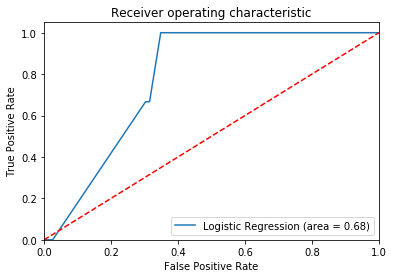

In [53]:
# Print ROC AUC Curve

logit_roc_auc = roc_auc_score(y01_test, bestlogreg.predict(x01_test))
fpr, tpr, thresholds = roc_curve(y01_test, bestlogreg.predict_proba(x01_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# Save the model as PMML File

In [54]:
# Save the model as a pmml and use to make predictions in a file 

joblib.dump(bestlogreg, 'LifeAgentChurnModel.pmml') 

['LifeAgentChurnModel.pmml']

# TPOT


In [73]:
#Using x,y before feature selection for TPOT classifier.

In [62]:
# Perform Test/Train Split
x_train, x_test, y_train, y_test=train_test_split(x01, y01, test_size=0.3,random_state=11)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7284, 10), (3123, 10), (7284,), (3123,))

In [63]:
# To handle class imbalance performing SMOTE

from imblearn.over_sampling import SMOTE
SMO = SMOTE(random_state=11)

x_train_smo,y_train_smo = SMO.fit_sample(x_train, y_train)
columns = x_train.columns

x_train_smo = pd.DataFrame(data = x_train_smo, columns = columns )
y_train_smo = pd.DataFrame(data = y_train_smo, columns = ['Churn'])

# we can Check the numbers of our data
print("length of oversampled data is ",len(x_train_smo))
print("Number of Churned agents in oversampled data",len(y_train_smo[y_train_smo['Churn']== 0 ]))
print("Number of Non Churned agents in oversampled data",len(y_train_smo[y_train_smo['Churn']== 1 ]))
print("Proportion of Non Churned agents in oversampled data is ",len(y_train_smo[y_train_smo['Churn']== 0])/len(x_train_smo))
print("Proportion of Churned Agents in oversampled data is ",len(y_train_smo[y_train_smo['Churn']== 1 ])/len(x_train_smo))

length of oversampled data is  14556
Number of Churned agents in oversampled data 7278
Number of Non Churned agents in oversampled data 7278
Proportion of Non Churned agents in oversampled data is  0.5
Proportion of Churned Agents in oversampled data is  0.5


In [64]:
#Import tpot classifier from tpot and initialize it to run for max generation = 5 OR max time = 60 mins
from tpot import TPOTClassifier
tpot = TPOTClassifier(generations=5, verbosity=2, max_time_mins=60, n_jobs = -1)
tpot.fit(x_train_smo, y_train_smo)
print(tpot.score(x_test, y_test))

Generation 1 - Current best internal CV score: 0.8485849666479176
Generation 2 - Current best internal CV score: 0.8486536479665988
Generation 3 - Current best internal CV score: 0.8486536479665988
Generation 4 - Current best internal CV score: 0.8486536479665988
Generation 5 - Current best internal CV score: 0.8487223292852801

Best pipeline: DecisionTreeClassifier(XGBClassifier(SGDClassifier(RBFSampler(input_matrix, gamma=0.55), alpha=0.001, eta0=0.01, fit_intercept=False, l1_ratio=0.0, learning_rate=constant, loss=modified_huber, penalty=elasticnet, power_t=1.0), learning_rate=0.1, max_depth=2, min_child_weight=20, n_estimators=100, nthread=1, subsample=0.5), criterion=gini, max_depth=4, min_samples_leaf=6, min_samples_split=11)
0.6974063400576369


In [65]:
TPOT_Fit_pipeline=tpot.fitted_pipeline_
TPOT_Fit_pipeline

Pipeline(memory=None,
         steps=[('rbfsampler',
                 RBFSampler(gamma=0.55, n_components=100, random_state=None)),
                ('stackingestimator-1',
                 StackingEstimator(estimator=SGDClassifier(alpha=0.001,
                                                           average=False,
                                                           class_weight=None,
                                                           early_stopping=False,
                                                           epsilon=0.1,
                                                           eta0=0.01,
                                                           fit_intercept=False,
                                                           l1_ratio=0.0,
                                                           learning_rate='constant',
                                                           loss='modified_huber',
                                                           ma

In [66]:
print(tpot.score(x_test, y_test))

0.6974063400576369


In [67]:
# Make Predictions
y_pred_TPOT=TPOT_Fit_pipeline.predict(x_test)

In [68]:
# Make Confusion Matrix to compare results against actuals
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_TPOT)
cnf_matrix  

array([[2176,  944],
       [   1,    2]], dtype=int64)

In [69]:
# # Get Accuracy Scores - y_test vs y_pred_TPOT
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_TPOT))
print("Precision:",metrics.precision_score(y_test, y_pred_TPOT))
print("Recall:",metrics.recall_score(y_test, y_pred_TPOT))
print("f1 score: ", f1_score(y_test, y_pred_TPOT))

Accuracy: 0.6974063400576369
Precision: 0.0021141649048625794
Recall: 0.6666666666666666
f1 score:  0.004214963119072709


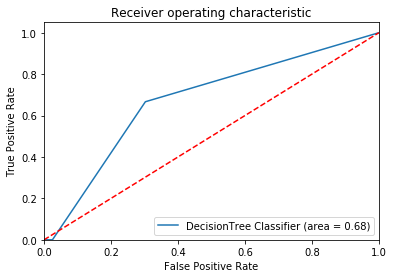

In [72]:
# Print ROC AUC Curve 
 
TPOT_roc_auc = roc_auc_score(y_test, TPOT_Fit_pipeline.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, TPOT_Fit_pipeline.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='DecisionTree Classifier (area = %0.2f)' % TPOT_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('pnc_Agt_churn_topt_ROC')
plt.show()

In [74]:
joblib.dump(bestlogreg, 'LifeAgentChurnTPOTModel.pmml') 

['LifeAgentChurnTPOTModel.pmml']